In [95]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Fetched 336 kB in 4s (87.1 kB/s)
Reading package lists... Done


### Deliverable 3: Optimize the Model: Leaving 'NAME' feature



#### Preprocessing the Data for a Neural Network

In [96]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("https://raw.githubusercontent.com/ArmineKhanan/Neural_Network_Charity_Analysis/main/Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [97]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(['EIN'], axis=1)

In [98]:
# Determine the number of unique values in each column.
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df.nunique()

NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [99]:
application_df["NAME"].value_counts().value_counts()

1      18776
2        215
3        103
4         72
5         48
       ...  
103        1
104        1
105        1
106        1
49         1
Name: NAME, Length: 92, dtype: int64

In [100]:
application_df["NAME"].value_counts().value_counts()/application_df["NAME"].value_counts().value_counts().sum()

1      0.959526
2      0.010987
3      0.005264
4      0.003679
5      0.002453
         ...   
103    0.000051
104    0.000051
105    0.000051
106    0.000051
49     0.000051
Name: NAME, Length: 92, dtype: float64

In [101]:
# Determine which values to replace if counts are less than ...?
replace_name = application_df["NAME"].value_counts() \
    [application_df["NAME"].value_counts() < 5] \
    .index.tolist()

# Replace in dataframe
for name in replace_name:
    application_df.NAME = application_df.NAME.replace(name,"Other")
    
# Check to make sure binning was successful
application_df.NAME.value_counts()

Other                                                                19803
PARENT BOOSTER USA INC                                                1260
TOPS CLUB INC                                                          765
UNITED STATES BOWLING CONGRESS INC                                     700
WASHINGTON STATE UNIVERSITY                                            492
                                                                     ...  
GUILDS OF THE SANTA FE OPERA INC                                         5
FAMILY MOTOR COACH ASSOCIATION                                           5
JAMESTOWN SOCIETY                                                        5
MOST WORSHIPFUL PRINCE HALL GRAND LODGE OF FREE & ACCEPTED MASONS        5
PTA HAWAII CONGRESS                                                      5
Name: NAME, Length: 403, dtype: int64

In [102]:
# Look at APPLICATION_TYPE value counts for binning
application_df["APPLICATION_TYPE"].value_counts()

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

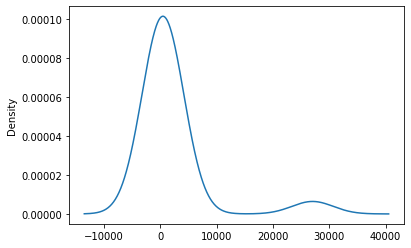

In [103]:
# Visualize the value counts of APPLICATION_TYPE
application_df["APPLICATION_TYPE"].value_counts().plot.density()

In [104]:
# Determine which values to replace if counts are less than ...?
replace_application = application_df["APPLICATION_TYPE"].value_counts() \
    [application_df["APPLICATION_TYPE"].value_counts() < 500] \
    .index.tolist()

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [105]:
# Look at CLASSIFICATION value counts for binning
application_df["CLASSIFICATION"].value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

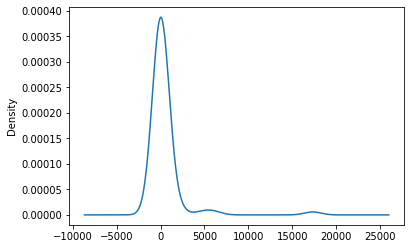

In [106]:
# Visualize the value counts of CLASSIFICATION
application_df["CLASSIFICATION"].value_counts().plot.density()

In [107]:
# Determine which values to replace if counts are less than ..?
replace_class = application_df["CLASSIFICATION"].value_counts() \
    [application_df["CLASSIFICATION"].value_counts() < 100] \
    .index.tolist()

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
Other      669
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
Name: CLASSIFICATION, dtype: int64

In [108]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
application_df[application_cat].nunique().index.tolist()

['NAME',
 'APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [109]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,NAME_AACE INTERNATIONAL,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_ACTS MINISTRY,NAME_ACTS MISSIONS,NAME_AFRICAN-AMERICAN POSTAL LEAGUE UNITED FOR SUCCESS A-PLUS,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALBANY STATE UNIVERSITY NATIONAL ALUMNI ASSOCIATION,NAME_ALPHA PHI OMEGA,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [110]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True, right_index=True)
application_df = application_df.drop(application_cat,1)
application_df.head()

<ipython-input-110-fae914666e78>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  application_df = application_df.drop(application_cat,1)


,STATUS,ASK_AMT,IS_SUCCESSFUL,NAME_AACE INTERNATIONAL,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_ACTS MINISTRY,NAME_ACTS MISSIONS,NAME_AFRICAN-AMERICAN POSTAL LEAGUE UNITED FOR SUCCESS A-PLUS,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [111]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=28)

<ipython-input-111-99378d8154c2>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = application_df.drop(["IS_SUCCESSFUL"],1).values


In [112]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#### Compile, Train and Evaluate the Model

In [113]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_of_input_features = len(X_train[0])
hidden_layer1_nodes = 30
hidden_layer2_nodes = 25

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_layer1_nodes, input_dim = number_of_input_features, activation = 'tanh'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_layer2_nodes, input_dim = number_of_input_features, activation = 'tanh'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="tanh"))

# Check the structure of the model
nn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 30)                13590     
                                                                 
 dense_16 (Dense)            (None, 25)                775       
                                                                 
 dense_17 (Dense)            (None, 1)                 26        
                                                                 
Total params: 14,391
Trainable params: 14,391
Non-trainable params: 0
_________________________________________________________________


In [114]:
# Compile the model
import os 
#from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

nn.compile(loss="binary_crossentropy", optimizer="adam", metrics= ["accuracy"])

In [115]:
# Train the model
fit_model= nn.fit(X_train_scaled, y_train, epochs=100,validation_split = 0.15, verbose=1)

Epoch 1/100
684/684 [==============================] - 4s 5ms/step - loss: 1.4827 - accuracy: 0.7208 - val_loss: 0.9173 - val_accuracy: 0.7681
Epoch 2/100
684/684 [==============================] - 4s 6ms/step - loss: 0.9220 - accuracy: 0.7597 - val_loss: 0.8448 - val_accuracy: 0.7676
Epoch 3/100
684/684 [==============================] - 4s 5ms/step - loss: 0.8331 - accuracy: 0.7714 - val_loss: 0.7529 - val_accuracy: 0.7792
Epoch 4/100
684/684 [==============================] - 3s 4ms/step - loss: 0.7018 - accuracy: 0.7721 - val_loss: 0.6211 - val_accuracy: 0.7771
Epoch 5/100
684/684 [==============================] - 4s 5ms/step - loss: 0.6331 - accuracy: 0.7833 - val_loss: 0.6060 - val_accuracy: 0.7893
Epoch 6/100
684/684 [==============================] - 2s 2ms/step - loss: 0.6239 - accuracy: 0.7893 - val_loss: 0.6162 - val_accuracy: 0.7880
Epoch 7/100
684/684 [==============================] - 2s 2ms/step - loss: 0.6074 - accuracy: 0.7879 - val_loss: 0.5818 - val_accuracy: 0.7896

In [119]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5396 - accuracy: 0.7978 - 349ms/epoch - 1ms/step
Loss: 0.5395715832710266, Accuracy: 0.7977842688560486


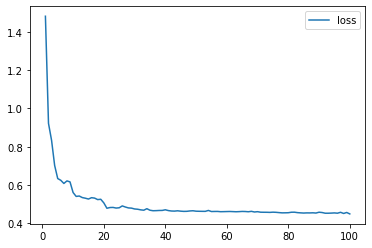

In [120]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

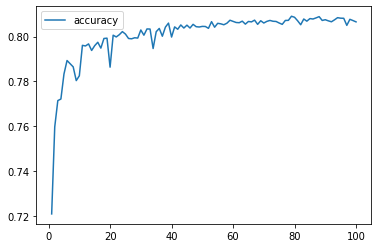

In [121]:
# Plot the accuracy
history_df.plot(y="accuracy")